# 16CygB

In [4]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk


import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2024-10-17 15:38:34.455334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 15:38:34.466002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 15:38:34.469242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 15:38:35.025768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import pitchfork

In [5]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## save observed/published parameters

In [11]:
#parameters for star, [value,unc], NaN for not found/published
#1 : Davies, G.R, 2015
#2 : Metcalfe, T, 2012
#3 : Ramirez, Melendez, Asplund, 2009
#4 : Lund, M., 2017

star_name = '16CygB'

star_dict={}

star_dict['initial_mass']=[1.07, 0.02] #2
star_dict['initial_Zinit']= [0.023, 0.002] #2
star_dict['initial_Yinit']= [0.25, 0.01] #2
star_dict['initial_MLT']= [1.92, 0.09] #2
star_dict['star_age']=[6.7, 0.4] #2

star_dict['calc_effective_T']=[5750, 50]  #3
star_dict['radius']=[1.127, 0.007] #2
star_dict['luminosity']=[1.27, 0.04] #2
star_dict['star_feh']=[0.052, 0.021] #3
star_dict['nu_0_6']=[np.nan, np.nan]
star_dict['nu_0_7']=[np.nan, np.nan]
star_dict['nu_0_8']=[np.nan, np.nan]
star_dict['nu_0_9']=[np.nan, np.nan]
star_dict['nu_0_10']=[np.nan, np.nan]
star_dict['nu_0_11']=[np.nan, np.nan]
star_dict['nu_0_12']=[np.nan, np.nan]
star_dict['nu_0_13']=[1695.07, 0.09] #1
star_dict['nu_0_14']=[1812.43, 0.1] #1
star_dict['nu_0_15']=[1928.90, 0.08] #1
star_dict['nu_0_16']=[2044.28, 0.06] #1
star_dict['nu_0_17']=[2159.58, 0.06] #1
star_dict['nu_0_18']=[2275.95, 0.05] #1
star_dict['nu_0_19']=[2392.71, 0.04] #1
star_dict['nu_0_20']=[2509.67, 0.04] #1
star_dict['nu_0_21']=[2626.40, 0.04] #1
star_dict['nu_0_22']=[2743.33, 0.06] #1
star_dict['nu_0_23']=[2860.72, 0.1] #1
star_dict['nu_0_24']=[2978.50, 0.15] #1
star_dict['nu_0_25']=[3096.85, 0.42] #1
star_dict['nu_0_26']=[3214.93, 1.04] #1
star_dict['nu_0_27']=[3334.22, 1.9] #1
star_dict['nu_0_28']=[np.nan, np.nan]
star_dict['nu_0_29']=[np.nan, np.nan]
star_dict['nu_0_30']=[np.nan, np.nan]
star_dict['nu_0_31']=[np.nan, np.nan]
star_dict['nu_0_32']=[np.nan, np.nan]
star_dict['nu_0_33']=[np.nan, np.nan]
star_dict['nu_0_34']=[np.nan, np.nan]
star_dict['nu_0_35']=[np.nan, np.nan]
star_dict['nu_0_36']=[np.nan, np.nan]
star_dict['nu_0_37']=[np.nan, np.nan]
star_dict['nu_0_38']=[np.nan, np.nan]
star_dict['nu_0_39']=[np.nan, np.nan]
star_dict['nu_0_40']=[np.nan, np.nan]

star_dict['dnu']=[116.929, 0.012] #4
star_dict['nu_max']=[2561.3, 5.3] #4 

with open(f'stars/{star_name}/{star_name}.json', 'w') as fp:
    json.dump(star_dict, fp)

star_dict

{'initial_mass': [1.07, 0.02],
 'initial_Zinit': [0.023, 0.002],
 'initial_Yinit': [0.25, 0.01],
 'initial_MLT': [1.92, 0.09],
 'star_age': [6.7, 0.4],
 'calc_effective_T': [5750, 50],
 'radius': [1.127, 0.007],
 'luminosity': [1.27, 0.04],
 'star_feh': [0.052, 0.021],
 'nu_0_6': [nan, nan],
 'nu_0_7': [nan, nan],
 'nu_0_8': [nan, nan],
 'nu_0_9': [nan, nan],
 'nu_0_10': [nan, nan],
 'nu_0_11': [nan, nan],
 'nu_0_12': [nan, nan],
 'nu_0_13': [1695.07, 0.09],
 'nu_0_14': [1812.43, 0.1],
 'nu_0_15': [1928.9, 0.08],
 'nu_0_16': [2044.28, 0.06],
 'nu_0_17': [2159.58, 0.06],
 'nu_0_18': [2275.95, 0.05],
 'nu_0_19': [2392.71, 0.04],
 'nu_0_20': [2509.67, 0.04],
 'nu_0_21': [2626.4, 0.04],
 'nu_0_22': [2743.33, 0.06],
 'nu_0_23': [2860.72, 0.1],
 'nu_0_24': [2978.5, 0.15],
 'nu_0_25': [3096.85, 0.42],
 'nu_0_26': [3214.93, 1.04],
 'nu_0_27': [3334.22, 1.9],
 'nu_0_28': [nan, nan],
 'nu_0_29': [nan, nan],
 'nu_0_30': [nan, nan],
 'nu_0_31': [nan, nan],
 'nu_0_32': [nan, nan],
 'nu_0_33': [nan,

## define priors

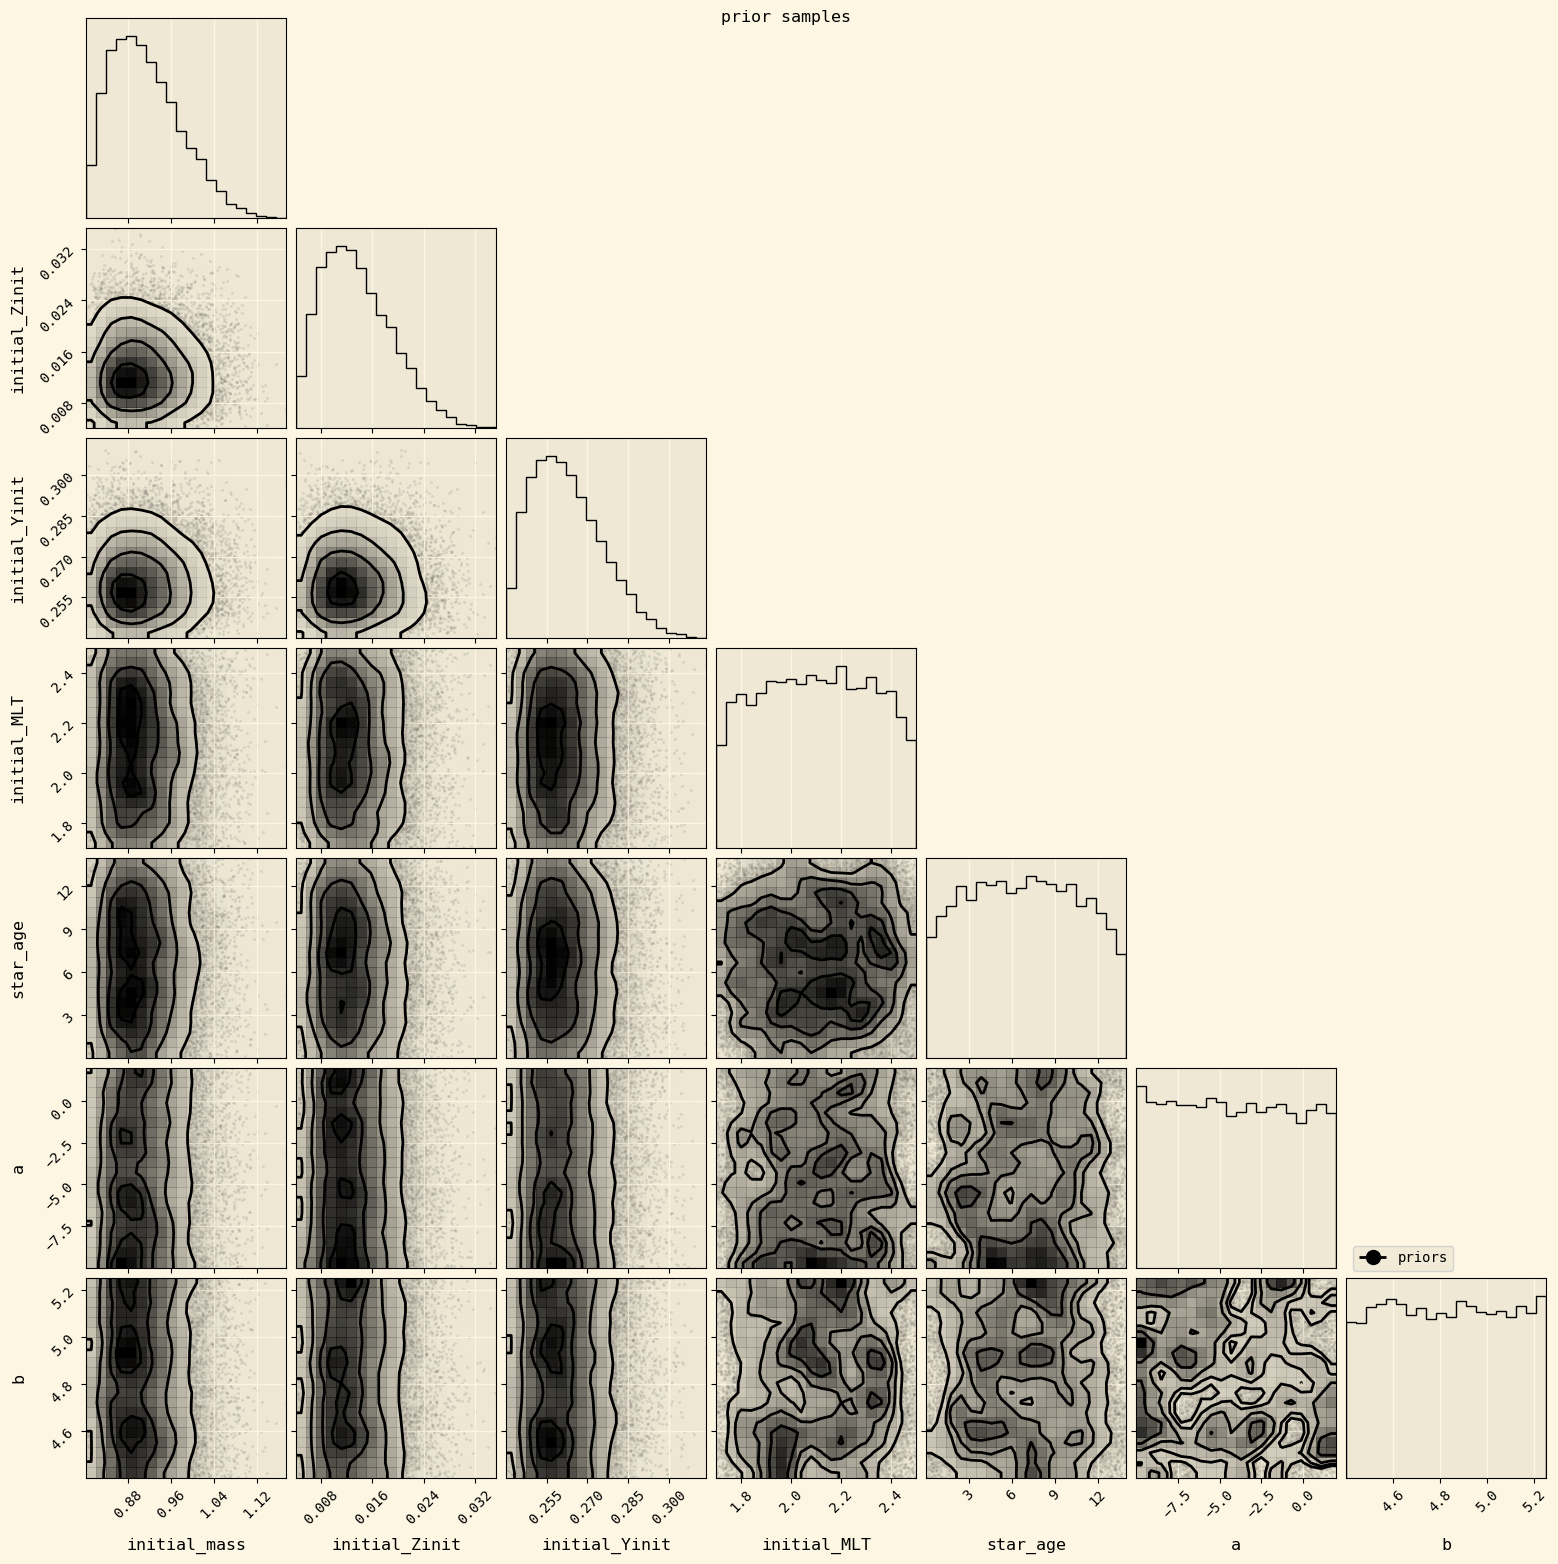

In [7]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## pre-sampling step
define relevant covariance matrices for likelihood, inputs and outputs etc

In [12]:
path = f'stars/{star_name}/'

star_json = path + f'{star_name}.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = 1*kernels.ExpSquared(scale=5*dnu)

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

In [10]:
%%time

import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

    
ndraw_min=2**16
ndraw_max=2**21

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = ultra_ns_vector_surface(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.4, max_ncalls=5e6)
with open(path+'/samples.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

sampler.cleanup()
del results

|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|           1.07 |           0.023 |           0.025 |          1.92 |        6.7 |


/home/oxs235/miniconda3/envs/jaxtf/lib/python3.12/site-packages/ultranest/integrator.py:1896: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


CPU times: user 8min 26s, sys: 14.7 s, total: 8min 41s*| it/evals=6265/697984 eff=0.5933% N=400 
Wall time: 8min 30s


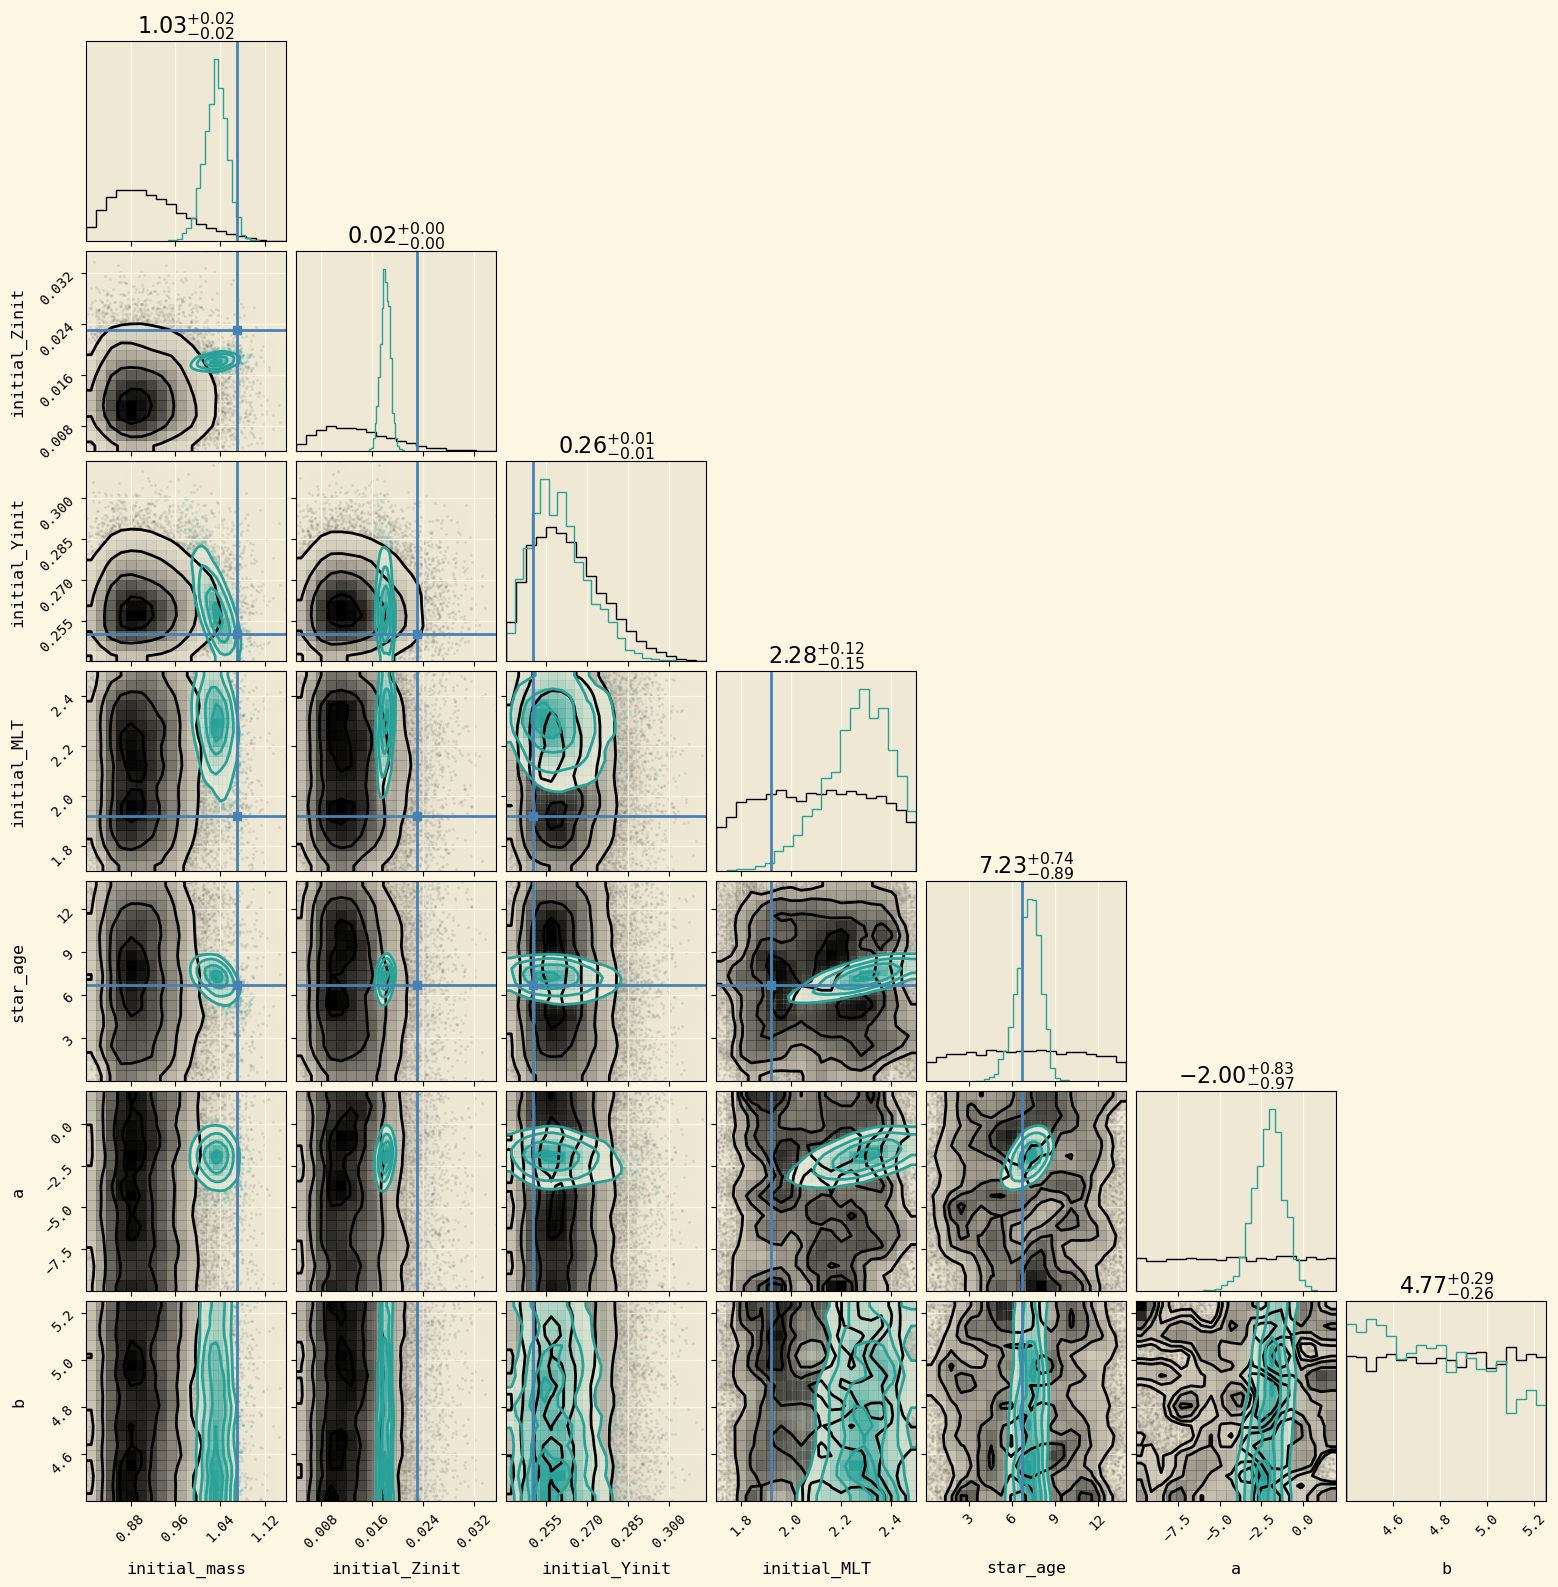

In [14]:
def inspect_star(path):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    
    path = f'stars/{star_name}/'
    
    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

    with open(path+f'/samples.pkl', 'rb') as fp:
     samples = pickle.load(fp)
        
    corner.corner(samples['samples'], fig=figure, color=colors[1], truths = published_inps, hist_kwargs={'density':True}, smooth=True,show_titles=True);

    plt.show()

    
inspect_star(path)